SC making the NN a pytorch model

In [1]:
print("Sc Vax Classify")

Sc Vax Classify


In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import f_classif

import pandas as pd
import numpy as np

import tensorflow as tf

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


In [178]:
# get the data
df = pd.read_csv("data/train_val.csv")
df.head()

,ID,tweet,labels
0,1296010336907038720t,@cath__kath AstraZeneca is made with the kidne...,ingredients
1,1336808189677940736t,It begins. Please find safe alternatives to th...,side-effect
2,1329488407307956231t,"@PaolaQP1231 Well, I mean congratulations Covi...",side-effect
3,1364194604459900934t,@BorisJohnson for those of us that do not wish...,mandatory
4,1375938799247765515t,She has been trying to speak out: writing lett...,side-effect rushed


In [4]:
# std defn
num_classes = 2

In [5]:
# split data for each class
attr = [
    "unnecessary",
    "mandatory",
    "pharma",
    "conspiracy",
    "political",
    "country",
    "rushed",
    "ingredients",
    "side-effect",
    "ineffective",
    "religious",
    "none",
]

accuracies = {}
# split data for each class

# copy the df and modify such that for those rows where the string value of labels column contains 'unnecessary', set the label columnn to 1 else 0
# make a copy of the df and set it to another variable
df_unnecessary = df.copy()
df_unnecessary["unnecessary"] = df_unnecessary["labels"].apply(
    lambda x: 1 if "unnecessary" in x else 0
)

# copy the df and modify such that for those rows where the string value of labels column contains 'mandatory', set the label columnn to 1 else 0
df_mandatory = df.copy()
df_mandatory["mandatory"] = df_mandatory["labels"].apply(
    lambda x: 1 if "mandatory" in x else 0
)

# copy the df and modify such that for those rows where the string value of labels column contains 'pharma', set the label columnn to 1 else 0
df_pharma = df.copy()
df_pharma["pharma"] = df_pharma["labels"].apply(lambda x: 1 if "pharma" in x else 0)

# copy the df and modify such that for those rows where the string value of labels column contains 'conspiracy', set the label columnn to 1 else 0
df_conspiracy = df.copy()
df_conspiracy["conspiracy"] = df_conspiracy["labels"].apply(
    lambda x: 1 if "conspiracy" in x else 0
)

# copy the df and modify such that for those rows where the string value of labels column contains 'political', set the label columnn to 1 else 0
df_political = df.copy()
df_political["political"] = df_political["labels"].apply(
    lambda x: 1 if "political" in x else 0
)

# copy the df and modify such that for those rows where the string value of labels column contains 'country', set the label columnn to 1 else 0
df_country = df.copy()
df_country["country"] = df_country["labels"].apply(lambda x: 1 if "country" in x else 0)

# copy the df and modify such that for those rows where the string value of labels column contains 'rushed', set the label columnn to 1 else 0
df_rushed = df.copy()
df_rushed["rushed"] = df_rushed["labels"].apply(lambda x: 1 if "rushed" in x else 0)

# copy the df and modify such that for those rows where the string value of labels column contains 'ingredients', set the label columnn to 1 else 0
df_ingredients = df.copy()
df_ingredients["ingredients"] = df_ingredients["labels"].apply(
    lambda x: 1 if "ingredients" in x else 0
)

# copy the df and modify such that for those rows where the string value of labels column contains 'side-effect', set the label columnn to 1 else 0
df_side_effect = df.copy()
df_side_effect["side-effect"] = df_side_effect["labels"].apply(
    lambda x: 1 if "side-effect" in x else 0
)

# copy the df and modify such that for those rows where the string value of labels column contains 'ineffective', set the label columnn to 1 else 0
df_ineffective = df.copy()
df_ineffective["ineffective"] = df_ineffective["labels"].apply(
    lambda x: 1 if "ineffective" in x else 0
)

# copy the df and modify such that for those rows where the string value of labels column contains 'religious', set the label columnn to 1 else 0
df_religious = df.copy()
df_religious["religious"] = df_religious["labels"].apply(
    lambda x: 1 if "religious" in x else 0
)

# copy the df and modify such that for those rows where the string value of labels column contains 'none', set the label columnn to 1 else 0
df_none = df.copy()
df_none["none"] = df_none["labels"].apply(lambda x: 1 if "none" in x else 0)

df_all = [
    df_unnecessary,
    df_mandatory,
    df_pharma,
    df_conspiracy,
    df_political,
    df_country,
    df_rushed,
    df_ingredients,
    df_side_effect,
    df_ineffective,
    df_religious,
    df_none,
]

In [6]:
def ngram_vectorize(train_texts, train_labels, val_texts):
    # Vectorization parameters
    # Range (inclusive) of n-gram sizes for tokenizing text.
    NGRAM_RANGE = (1, 2)

    # Limit on the number of features. We use the top 20K features.
    TOP_K = 2000

    # Whether text should be split into word or character n-grams.
    # One of 'word', 'char'.
    TOKEN_MODE = "word"

    # Minimum document/corpus frequency below which a token will be discarded.
    MIN_DOCUMENT_FREQUENCY = 2
    # Create keyword arguments to pass to the 'tf-idf' vectorizer.
    kwargs = {
        "ngram_range": NGRAM_RANGE,  # Use 1-grams + 2-grams.
        "dtype": np.float64,
        "strip_accents": "unicode",
        "decode_error": "replace",
        "analyzer": TOKEN_MODE,  # Split text into word tokens.
        "min_df": MIN_DOCUMENT_FREQUENCY,
    }
    vectorizer = TfidfVectorizer(**kwargs)

    # Learn vocabulary from training texts and vectorize training texts.
    x_train = vectorizer.fit_transform(train_texts)

    # Vectorize validation texts.
    x_val = vectorizer.transform(val_texts)

    # Select top 'k' of the vectorized features.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype("float32")
    x_val = selector.transform(x_val).astype("float32")
    return x_train, x_val

In [7]:
def get_accuracy(model, x_val, y_val):
    # Set the model to evaluation mode.
    model.eval()

    # Compute the predictions on the validation set.
    with torch.no_grad():
        logits = model(x_val)
        predictions = torch.argmax(logits, dim=1)

    # Compute the accuracy of the model on the validation set.
    correct_predictions = torch.eq(predictions, y_val).sum().item()
    total_predictions = y_val.shape[0]
    accuracy = correct_predictions / total_predictions

    return accuracy

In [8]:
# pytorch nn model
import torch.nn as nn


class MLP(nn.Module):
    def __init__(self, layers, units, dropout_rate, input_shape, num_classes):
        super(MLP, self).__init__()
        self.dropout = nn.Dropout(p=dropout_rate)
        self.fc1 = nn.Linear(input_shape, units)
        self.relu1 = nn.ReLU()
        self.layers = nn.ModuleList()
        for _ in range(layers - 1):
            self.layers.append(nn.Linear(units, units))
            self.layers.append(nn.ReLU())
            self.layers.append(nn.Dropout(p=dropout_rate))
        self.fc2 = nn.Linear(units, num_classes)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.relu1(x)
        for layer in self.layers:
            x = layer(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

we have a bunch of options in front of us: binary chain, ensembling (best but maybe complex to choose b/w ensembling methods), power set (not rec)

In [9]:
def train_ngram_model(
    data,
    name,
    learning_rate=10e-3,
    epochs=10,
    batch_size=128,
    layers=2,
    units=64,
    dropout_rate=0.2,
):
    # Get the data.
    (train_texts, train_labels), (val_texts, val_labels) = data

    # Vectorize texts.
    x_train, x_val = ngram_vectorize(train_texts, train_labels, val_texts)
    #print(x_train.shape)
    x_train_int = int(x_train.shape[0]), int(x_train.shape[1])
    #Create model instance.
    model = MLP(
        layers=layers,
        units=units,
        dropout_rate=dropout_rate,
        input_shape=x_train_int[1],
        num_classes=2,
    )

    
    # Compile model with learning parameters.
    if num_classes == 2:
        loss = "binary_crossentropy"
    else:
        loss = "sparse_categorical_crossentropy"

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()
    x_train = torch.from_numpy(x_train.toarray()).float()
    train_tuple = torch.tensor(train_labels.values)
    y_train = F.one_hot(train_tuple, num_classes=2).float()

    # Create a TensorDataset from your training data.
    train_dataset = TensorDataset(x_train, y_train)

    # Create a DataLoader from the TensorDataset.
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    
    callbacks = [tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=2)]

    num_epochs = epochs

    try:
        model.load_state_dict(torch.load("models/model" + name +".pt"))
    except:
        for epoch in range(num_epochs):
            for i, (inputs, labels) in enumerate(train_loader):
                # Zero the gradients.
                optimizer.zero_grad()

                # Forward pass.
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                # Backward pass.
                loss.backward()

                # Update the parameters.
                optimizer.step()

                # Print the loss.
                if (i+1) % 10 == 0:
                    print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                        .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

    first_row = x_val.toarray()[0]

    x_val_tensor = torch.from_numpy(x_val.toarray()).float()
    y_val_tensor = torch.tensor(val_labels.values)
    accuracy = get_accuracy(model, x_val_tensor, y_val_tensor)

    # Print the accuracy.
    print("Validation accuracy:", accuracy)
    accuracies[name] = accuracy
    torch.save(model.state_dict(), "models/model" + name + ".pt")

    first_row_tensor = torch.tensor(first_row)

    train_labels_list = train_labels.tolist()

    misses = 0
    print("training")
    for ind, val in enumerate(train_labels_list):
        if True:
            first_row = x_val.toarray()[ind]
            first_row_tensor = torch.tensor(first_row)

            model.eval()
            with torch.no_grad():
                prediction = model.forward(first_row_tensor)

            
            prediction = prediction.tolist().index(max(prediction.tolist()))
            if prediction != val:
                misses += 1

            if ind > 1500:
                break

    print("misses", misses/1500)     

    model.eval()
    with torch.no_grad():
        prediction = model.forward(first_row_tensor)


    

In [10]:
for ind, i in enumerate(df_all):
    # Split the data into training and testing sets
    print(attr[ind])
    train_texts, val_texts, train_labels, val_labels = train_test_split(
        i.iloc[:, 1], i.iloc[:, -1], test_size=0.2, random_state=42
    )
    data = (train_texts, train_labels), (val_texts, val_labels)

    train_ngram_model(data, name=attr[ind])

unnecessary
Validation accuracy: 0.9299748110831234
training
misses 0.12
mandatory
Validation accuracy: 0.9355163727959698
training
misses 0.11333333333333333
pharma
Validation accuracy: 0.8846347607052897
training
misses 0.18466666666666667
conspiracy
Validation accuracy: 0.947103274559194
training
misses 0.07066666666666667
political
Validation accuracy: 0.9355163727959698
training
misses 0.10266666666666667
country
Validation accuracy: 0.980352644836272
training
misses 0.032
rushed
Validation accuracy: 0.9052896725440807
training
misses 0.21533333333333332
ingredients
Validation accuracy: 0.9551637279596977
training
misses 0.048666666666666664
side-effect
Validation accuracy: 0.8473551637279597
training
misses 0.478
ineffective
Validation accuracy: 0.8639798488664987
training
misses 0.24
religious
Validation accuracy: 0.9949622166246851
training
misses 0.007333333333333333
none
Validation accuracy: 0.9350125944584383
training
misses 0.09


In [15]:
print(accuracies)
print(attr)

{'unnecessary': 0.9299748110831234, 'mandatory': 0.9355163727959698, 'pharma': 0.8846347607052897, 'conspiracy': 0.947103274559194, 'political': 0.9355163727959698, 'country': 0.980352644836272, 'rushed': 0.9052896725440807, 'ingredients': 0.9551637279596977, 'side-effect': 0.8473551637279597, 'ineffective': 0.8639798488664987, 'religious': 0.9949622166246851, 'none': 0.9350125944584383}
['unnecessary', 'mandatory', 'pharma', 'conspiracy', 'political', 'country', 'rushed', 'ingredients', 'side-effect', 'ineffective', 'religious', 'none']


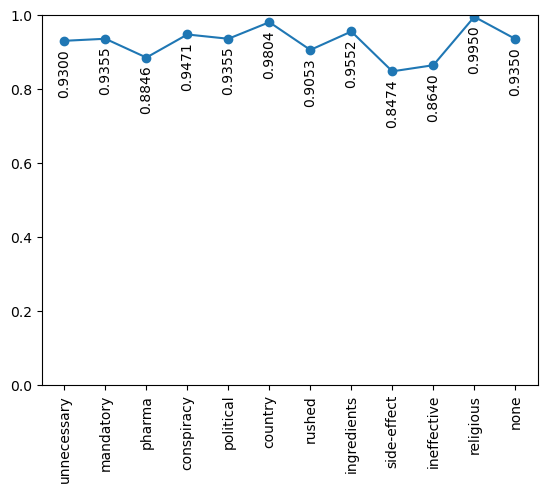

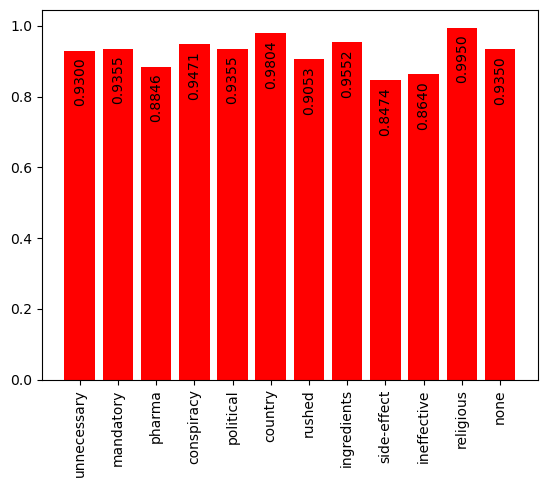

In [28]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 7))
x = range(len(accuracies))
X = list(accuracies.keys())
y = list(accuracies.values())
plt.plot(X, y, marker='o')
plt.xticks(x, X, rotation="vertical")
plt.ylim([0, 1])
for i in range(len(x)):
    plt.text(x[i], y[i]-0.02, f'{y[i]:.4f}', ha='center', va='top', rotation='vertical')
plt.show()
plt.bar(X, y, color='red')
plt.xticks(x, X, rotation="vertical")
for i in range(len(x)):
    plt.text(x[i], y[i]-0.02, f'{y[i]:.4f}', ha='center', va='top', rotation='vertical')
plt.show()